# Support Vector Machines nos dados covtype de LIBSVM

Iremos treinar os dados para classificação binária usando os dados `covtype` da biblioteca [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/). Veja também [Kaggle-LIBSVM](https://www.kaggle.com/code/tanmayunhale/libsvm-liblinear).

Desta vez, iremos usar o algoritmo SVM:

$$
\min_{w\in {\mathbb R}^{d\times1}} f_n(w)=\frac{1}{n}\sum_{i=1}^n \max\{0,1-y_i(x_i^\top w)\} + \frac{\gamma}{2}\|w\|^2,
$$

onde $x_i\in {\mathbb R}^{d\times1}$, $y_i\in \{-1, 1\}$. Uma diferença em relação à regressão logística é que a função custo não é diferenciável. Um subgradiente num ponto $w$ é dado por

$$
g_n(w) = -\frac{1}{n}\sum_{i=1}^n\mathbb{1}_{\{y_i(x_i^\top w)<1\}}y_ix_i + \gamma w.
$$

Portanto, poderíamos usar o método subgradiente. Neste projeto, entretanto, iremos considerar o caso em que $n$ é muito grande de modo que avaliar $f(w)$ ou $g(w)$ é muito custoso. Note que $f(w)$ é a média empírica de 

$$
F_i(w) := \max\{0,1-y_i(x_i^\top w)\} + \frac{\gamma}{2}\|w\|^2.
$$

Alternativamente iremos usar em cada iteração um único ponto da amostra e aplicar o método subgradiente estocástico com o subgradiente:

$$
G_i(w) := -\mathbb{1}_{\{y_i(x_i^\top w)<1\}}y_ix_i + \gamma w.
$$

NOTA: neste projeto os labels devem estar em $\{-1,1\}$!

In [1]:
# Importação de módulos necesserários:

import matplotlib
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file
from sklearn.utils.extmath import safe_sparse_dot

In [3]:
# Lendo os dados do arquivo covtype e guardando na matriz de dados X e vetor de labels y:

data = load_svmlight_file('./datasets/covtype')
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Devemos garantir que os labels estão em {-1, 1}
    y[y==1.] = -1
    y[y==2.] = 1
    
n, d = X.shape # tamanho da amostra, número de features    

# Exercício 1: Funções auxiliares

1. Construa uma função `f(w, l2, m)` que toma o iterado `w` e a penalização $\gamma$ (=`l2`) e retorna o valor funcional $f_{m}(w)$ para algum $m\in[n]$.
2. Construa uma função `G(w, i, l2)` toma o iterado `w`, os dados $(x_i,y_i)$ e a penalização $\gamma$ (=`l2`) e retorna o subgradiente $G_i(w)$.
3. Construa uma função `g(w, l2, m)` que toma o iterado `w` e a penalização $\gamma$ (=`l2`) e retorna o subgradiente  $g_{m}(w)$ para algum $m\in[n]$ --- isto é, a média de $m$ subgradientes.
4. Construa uma função `gB(w, l2, B)` que toma o iterado `w` e a penalização $\gamma$ (=`l2`) e retorna o gradiente  $g_{B}(w)=\frac{1}{B}\sum_{i\in I_B}G_i(w)$ para algum $B\in[n]$ onde $I_B\subset[n]$ é escolhido aleatoriamente/uniformente. 

In [ ]:
#Escreva o código aqui
def f(w, l2, m):
    sumatory = np.sum(np.maximum(0, 1 - y * (X @ w))[:m])
    return (1/n) * sumatory + (l2/2) * (la.norm(w) ** 2)

def G(w, i, l2):
    indicator = y[i] * (X[i, :] @ w) < 1
    if isinstance(i, int) or isinstance(i, np.int32):
        return  X[i, :] * indicator * (-y[i]) + l2 * w
    else:
        return  X[i, :] * (indicator * (-y[i]))[:, np.newaxis] + l2 * w

def g(w, l2, m):
    indicator = y * (X @ w) < 1
    sumatory = np.sum(((X * y[:, np.newaxis]) * indicator[:, np.newaxis])[:m, :], axis = 0)
    return (-1/m) * sumatory + l2 * w

def gB(w, l2, B):
    Ib = np.random.choice(range(n), size = B, replace = False)
    return (1/B) * np.sum(G(w, Ib, l2), axis = 0)

# Inicialização

Fixaremos:

In [ ]:
m = 30000
l2 = 1e+2
w0 = np.zeros(d)        # ponto inicial
it_max = 80000          # número de iterações
B = 100

# Exercício 2: Método subgradiente estocástico 1 

Iremos implementar o algoritmo [Pegasos](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.cs.huji.ac.il/~shais/papers/ShalevSiSrCo10.pdf)

Construa uma função `sgd(f, G, w0, lr, l2, m, it_max)` que toma como entrada as funções `g()` `G()`, o ponto inicial `w0`, a regularização `l2` $(=\gamma)$, passo `lr`,  `m` e implementa o método subgradiente estocástico em `it_max` iterações iniciando de `w0`:

$$
w_{k+1} = w_k - \alpha_k G_k(w_k), 
$$

com passo $\alpha_k=\frac{lr}{\gamma k}$. **Na $k$-ézima iteração, use o ponto amostral $(x_k,y_k)$, na ordem do data set `X,y`**. Esta função deve retornar a sequência 

$$
k\mapsto f_{m}(w_k)=\frac{1}{m}\sum_{i=1}^{m} \max\{0,1-y_i(x_i^\top w_k)\} + \frac{\gamma}{2}\|w_k\|^2.
$$  

A função também deve retornar o último iterado.

In [ ]:
#Escreva o código aqui
def sgd(f, G, w0, lr, l2, m, it_max):
    # Inicializando o histórico de erros
    error_history = []
    # Inicializando o w como w0
    w = w0.copy()

    # Em cada iteração...
    for k in range(it_max):
        # Calcula o alpha
        alpha = lr/(l2 * (k + 1))
        # Atualiza o w
        w -= alpha * G(w, k, l2)

        # Calcula o erro e salva na lista
        error = f(w, l2, m)
        error_history.append(error)

    return error_history, w

In [82]:
# gradient descent
f1 = sgd(f, G, w0, 1e-1, l2, m, it_max)

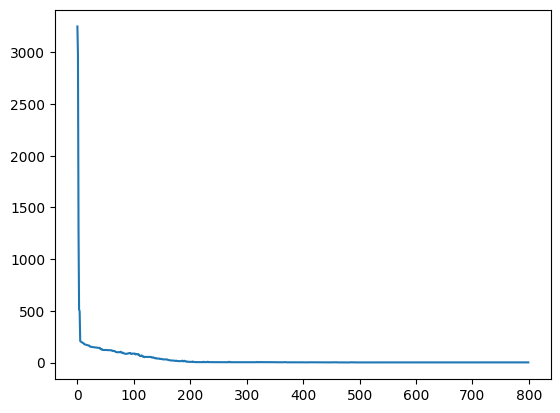

In [83]:
plt.plot(f1[0])

# Exercício 3: Método subgradiente estocástico 2

Construa uma função `sgd2(f, G, w0, lr, l2, m, it_max)` que toma como entrada as funções `g` `G()`, o ponto inicial `w0`, a regularização `l2` $(=\gamma)$, `m` e implementa o método subgradiente estocástico em `it_max` iterações iniciando de `w0`:

$$
w_{k+1} = w_k - \alpha_k G_{i_k}(w_k),
$$

com passo $\alpha_k=\frac{lr}{\gamma k}$, onde **na $k$-ézima iteração, $i_k\in[n]$ é escolhido uniformemente ao acaso, usand o ponto amostral $(x_{i_k},y_{i_k})$**. Esta função deve retornar a sequência 

$$
k\mapsto f_{m}(w_k)=\frac{1}{m}\sum_{i=1}^{m} \max\{0,1-y_i(x_i^\top w_k)\} + \frac{\gamma}{2}\|w_k\|^2.
$$ 

A função também deve retornar o último iterado.

In [108]:
#Escreva o código aqui
def sgd2(f, G, w0, lr, l2, m, it_max):
    # Inicializando o histórico de erros
    error_history = []
    # Inicializando o w como w0
    w = w0.copy()

    # Em cada iteração...
    for k in range(it_max):
        # Calcula o alpha
        alpha = lr/(l2 * (k + 1))
        # Sorteia o ik
        ik = np.random.choice(range(n), 1)[0]
        # Atualiza o w
        w -= alpha * G(w, ik, l2)

        # Calcula o erro e salva na lista
        error = f(w, l2, m)
        error_history.append(error)

    return error_history, w

In [106]:
# gradient descent
f2 = sgd2(f, G, w0, 1e-1, l2, m, it_max)

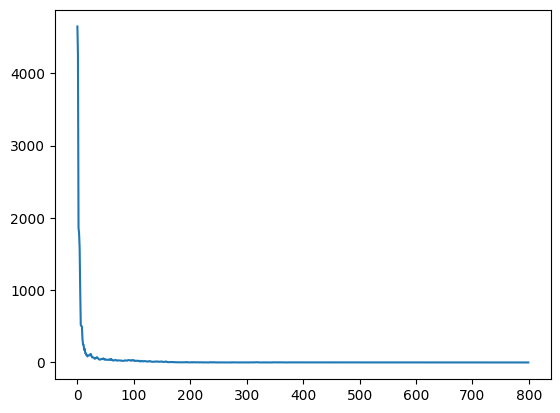

In [10]:
plt.plot(f2[0])

# Exercício 4: Método subgradiente estocástico 3

Construa agora função `sgd3(f, gB, w0, lr, l2, m, B, it_max)` que toma como entrada as funções `f` `gB()`, o ponto inicial `w0`, a regularização `l2` $(=\gamma)$ e implementa o método subgradiente estocástico com mini-batch size `B` em `it_max` iterações iniciando de `w0`:

$$
w_{k+1} = w_k - \alpha_k \cdot\frac{1}{B}\sum_{i\in B_k}G_{i}(w_k),
$$

onde **na $k$-ézima iteração, $B_k\subset\in[n]$ é escolhido uniformemente ao acaso, usando o mini-batch $\{(x_{i},y_{i})\}_{i\in B_k}$**. Esta função deve retornar a sequência 

$$
k \rightarrow f_{\text{max\_it}}(w^{(k)}) = \frac{1}{\text{max\_it}} \sum_{i=1}^{\text{max\_it}} \max \left( 0, 1 - y_i (x_i^{\top} w^{(k)}) \right) + \frac{\gamma}{2} \| w^{(k)} \|^2
$$

A função também deve retornar o último iterado. Implemente com passo $\alpha_k=\frac{lr}{\gamma k}$.  

In [111]:
#Escreva o código aqui
def sgd3(f, gB, w0, lr, l2, m, B, it_max):
    # Inicializando o histórico de erros
    error_history = []
    # Inicializando o w como w0
    w = w0.copy()

    # Em cada iteração...
    for k in range(it_max):
        # Calcula o alpha
        alpha = lr/(l2 * (k + 1))
        # Atualiza o w
        w -= alpha * gB(w, l2, B)

        # Calcula o erro e salva na lista
        error = f(w, l2, it_max)
        error_history.append(error)

    return error_history, w

In [112]:
f3 = sgd3(f, gB, w0, 1e-1, l2, m, B, it_max)

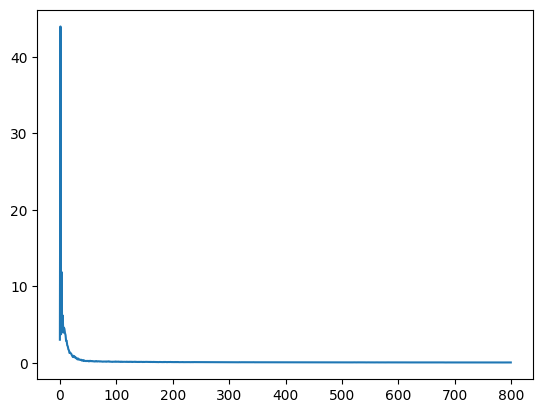

In [113]:
plt.plot(f3[0])

# Exercício 5: 

Implemente num mesmo gráfico os erros $f_{\text{it_max}}(w_k)$ de cada método em função no número de iterações.

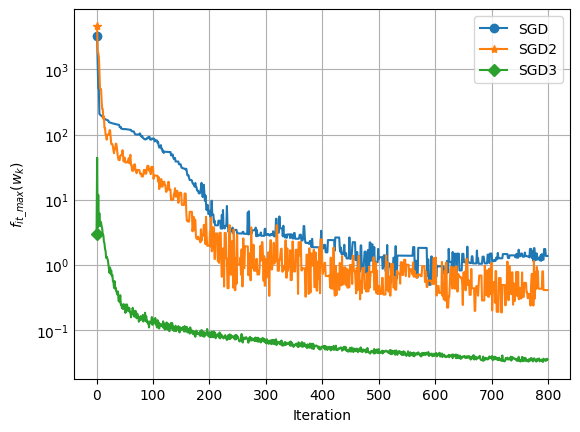

In [116]:
#Escreva o código aqui
def plot_errors(f1, f2, f3):
    # Plotando as linhas
    plt.plot(f1[0], label = "SGD", marker = "o", markevery = 3750)
    plt.plot(f2[0], label = "SGD2", marker = "*", markevery = 3750)
    plt.plot(f3[0], label = "SGD3", marker = "D", markevery = 3750)
    # Ajustando os eixos
    plt.xlabel("Iteration")
    plt.yscale("log")
    plt.ylabel(r"$f_{it\_max}(w_k)$")
    plt.tick_params(axis = "y", which = "both", length = 0)
    # Ativando a legenda e o grid
    plt.legend()
    plt.grid(True)

plot_errors(f1, f2, f3)

# Exercício 6:

Nos exercícios anteriores, usamos os $m$ primeiros pontos de dados `y[:m], X[:m]` para plotar a sequência $k\mapsto f_m(w_k)$. Isto não é ideal já que usamos também todo ou parte de `y[:m], X[:m]` para construir a sequência de iterados $k\mapsto w_k$. Refaça os 3 exercícios anteriores mas antes dividindo o data set `y, X` em duas partes 
`y[n-m:], X[n-m:]` e `y[:n-m], X[:n-m]`. Use o dataset `y[:n-m], X[:n-m]` de tamanho `n-m` para construir a sequência de iterados $k\mapsto w_k$ e `y[n-m:], X[n-m:]` de tamanho `m` para computar $f_m(w)$ para cada iterado $w$. Plote os 3 gráficos correspondentes e depois o gráfico com os 6 métodos diferentes. Você nota alguma diferença?

In [120]:
#Escreva o código aqui
X1, X2 = X[n-m:, :], X[:n-m, :]
y1, y2 = y[n-m:], y[:n-m]

def sgdm(f, G, w0, lr, l2, m, it_max):
    # Inicializando o histórico de erros
    error_history = []
    # Inicializando o w como w0
    w = w0.copy()

    # Em cada iteração...
    for k in range(it_max):
        # Calcula o alpha
        alpha = lr/(l2 * (k + 1))
        # Atualiza o w
        k = k % len(y2)
        w -= alpha * G(w, k, l2)

        # Calcula o erro e salva na lista
        error = f(w, l2, m)
        error_history.append(error)

    return error_history, w

def sgd2m(f, G, w0, lr, l2, m, it_max):
    # Inicializando o histórico de erros
    error_history = []
    # Inicializando o w como w0
    w = w0.copy()

    # Em cada iteração...
    for k in range(it_max):
        # Calcula o alpha
        alpha = lr/(l2 * (k + 1))
        # Sorteia o ik
        ik = np.random.choice(range(len(y2)), 1)[0]
        # Atualiza o w
        w -= alpha * G(w, ik, l2)

        # Calcula o erro e salva na lista
        error = f(w, l2, m)
        error_history.append(error)

    return error_history, w

def gBm(w, l2, B):
    Ib = np.random.choice(range(len(y2)), size = B, replace = False)
    return (1/B) * np.sum(G(w, Ib, l2), axis = 0)

def fm(w, l2, m):
    sumatory = np.sum(np.maximum(0, 1 - y1 * (X1 @ w))[:m])
    return (1/n) * sumatory + (l2/2) * (la.norm(w) ** 2)

In [123]:
#Escreva o código aqui
g1 = sgdm(fm, G, w0, 1e-1, l2, m, it_max)

In [124]:
#Escreva o código aqui
g2 = sgd2m(fm, G, w0, 1e-1, l2, m, it_max)

In [125]:
g3 = sgd3(fm, gBm, w0, 1e-1, l2, m, B, it_max)

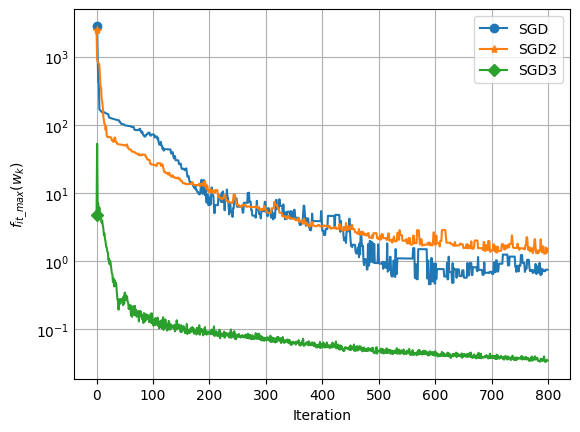

In [126]:
#Escreva o código aqui
plot_errors(g1, g2, g3)

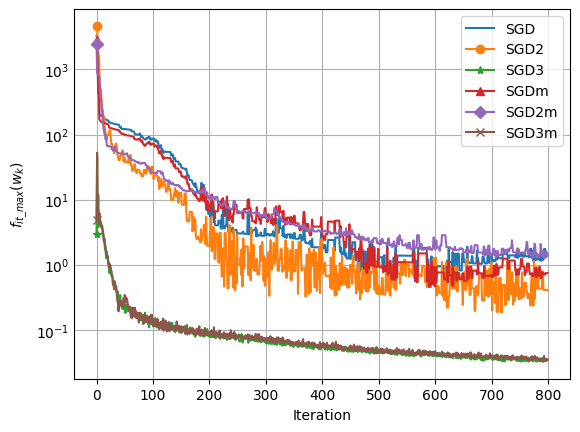

In [127]:
#Escreva o código aqui
# Plotando as linhas
plt.plot(f1[0], label = "SGD")
plt.plot(f2[0], label = "SGD2", marker = "o", markevery = 3750)
plt.plot(f3[0], label = "SGD3", marker = "*", markevery = 3750)
plt.plot(g1[0], label = "SGDm", marker = "^", markevery = 3750)
plt.plot(g2[0], label = "SGD2m", marker = "D", markevery = 3750)
plt.plot(g3[0], label = "SGD3m", marker = "x", markevery = 3750)
# Ajustando os eixos
plt.xlabel("Iteration")
plt.yscale("log")
plt.ylabel(r"$f_{it\_max}(w_k)$")
plt.tick_params(axis = "y", which = "both", length = 0)
# Ativando a legenda e o grid
plt.legend()
plt.grid(True)